In [14]:
# Imports

try:
    import numpy as np
    import pandas as pd
    import skfuzzy as fuzz
    import matplotlib.pyplot as plt
    from skfuzzy import control as ctrl
except Exception as e:
    print(e)
    %pip install -U numpy matplotlib scikit-fuzzy pandas scipy networkx

In [15]:
# Load the data
data = pd.read_csv('winequality-white.csv', sep=';')

# Select the relevant columns by name instead of using indices
X = data[['pH', 'alcohol', 'residual sugar']]  # Replace with actual column names
Y = data['quality']  # Quality column

print(X)

        pH  alcohol  residual sugar
0     3.00      8.8            20.7
1     3.30      9.5             1.6
2     3.26     10.1             6.9
3     3.19      9.9             8.5
4     3.19      9.9             8.5
...    ...      ...             ...
4893  3.27     11.2             1.6
4894  3.15      9.6             8.0
4895  2.99      9.4             1.2
4896  3.34     12.8             1.1
4897  3.26     11.8             0.8

[4898 rows x 3 columns]


In [16]:
# Function to generate triangular membership sets

def extract_key_values(x):
    MIN = min(x)
    MAX = max(x)
    
    a = 1.5  # Scaling factors
    b = 0.5
    c = 0.5
    
    q1 = np.quantile(x, 0.25)
    q2 = np.quantile(x, 0.50)  # Median
    q3 = np.quantile(x, 0.75)
    
    LL = max(MIN, q1 - a * (q3 - q1))
    HL = min(MAX, q3 + a * (q3 - q1))
    
    # Define v1 and v2 adjustments
    v1 = c * (LL - MIN)
    v2 = c * (MAX - HL)
    
    # Define triangular membership functions (three points each)
    ol = [MIN, MIN, LL]         # Left-most set (ol)
    low = [MIN, q1, q2]         # Low fuzzy set
    normal = [q1, q2, q3]       # Normal fuzzy set
    high = [q2, q3, HL]         # High fuzzy set
    oh = [HL, MAX, MAX]         # Right-most set (oh)
    
    return ol, low, normal, high, oh, MIN, MAX


C:\Users\kkiko\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


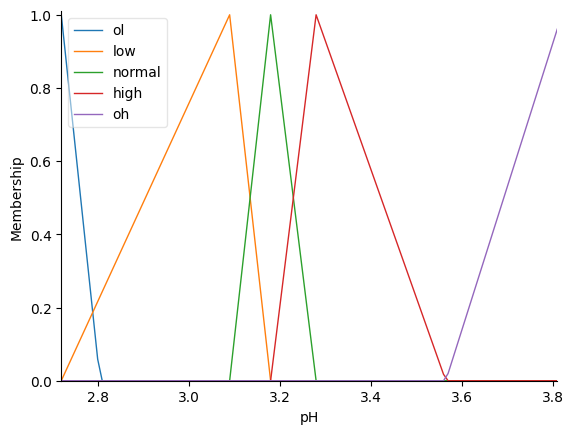

In [17]:
# Define fuzzy sets for pH
ol_pH, low_pH, normal_pH, high_pH, oh_pH, pH_min, pH_max = extract_key_values(X.iloc[:, 0].values)
pH = ctrl.Antecedent(np.arange(pH_min, pH_max, 0.01), 'pH')

# Define triangular membership functions for pH
pH['ol'] = fuzz.trimf(np.arange(pH_min, pH_max, 0.01), ol_pH)
pH['low'] = fuzz.trimf(np.arange(pH_min, pH_max, 0.01), low_pH)
pH['normal'] = fuzz.trimf(np.arange(pH_min, pH_max, 0.01), normal_pH)
pH['high'] = fuzz.trimf(np.arange(pH_min, pH_max, 0.01), high_pH)
pH['oh'] = fuzz.trimf(np.arange(pH_min, pH_max, 0.01), oh_pH)

pH.view()  

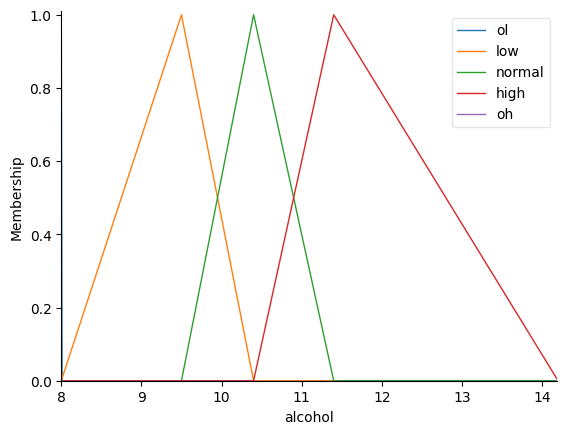

In [18]:
# Define fuzzy sets for Alcohol
ol_alcohol, low_alcohol, normal_alcohol, high_alcohol, oh_alcohol, alcohol_min, alcohol_max = extract_key_values(X.iloc[:, 1])
alcohol = ctrl.Antecedent(np.arange(alcohol_min, alcohol_max, 0.01), 'alcohol')

alcohol['ol'] = fuzz.trimf(np.arange(alcohol_min, alcohol_max, 0.01), ol_alcohol)
alcohol['low'] = fuzz.trimf(np.arange(alcohol_min, alcohol_max, 0.01), low_alcohol)
alcohol['normal'] = fuzz.trimf(np.arange(alcohol_min, alcohol_max, 0.01), normal_alcohol)
alcohol['high'] = fuzz.trimf(np.arange(alcohol_min, alcohol_max, 0.01), high_alcohol)
alcohol['oh'] = fuzz.trimf(np.arange(alcohol_min, alcohol_max, 0.01), oh_alcohol)

alcohol.view()  

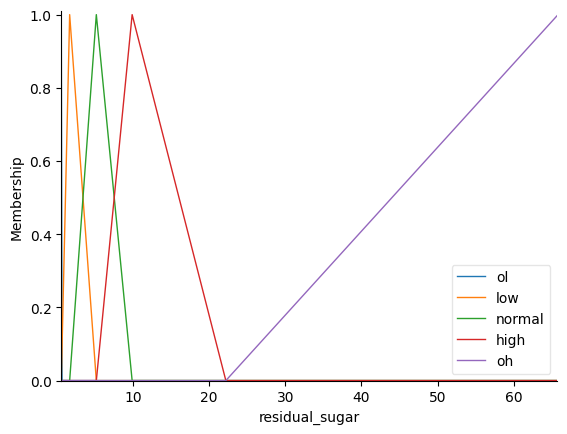

In [19]:
# Define fuzzy sets for Residual Sugar
ol_sugar, low_sugar, normal_sugar, high_sugar, oh_sugar, sugar_min, sugar_max = extract_key_values(X.iloc[:, 2])
sugar = ctrl.Antecedent(np.arange(sugar_min, sugar_max, 0.1), 'residual_sugar')

sugar['ol'] = fuzz.trimf(np.arange(sugar_min, sugar_max, 0.1), ol_sugar)
sugar['low'] = fuzz.trimf(np.arange(sugar_min, sugar_max, 0.1), low_sugar)
sugar['normal'] = fuzz.trimf(np.arange(sugar_min, sugar_max, 0.1), normal_sugar)
sugar['high'] = fuzz.trimf(np.arange(sugar_min, sugar_max, 0.1), high_sugar)
sugar['oh'] = fuzz.trimf(np.arange(sugar_min, sugar_max, 0.1), oh_sugar)

sugar.view()  

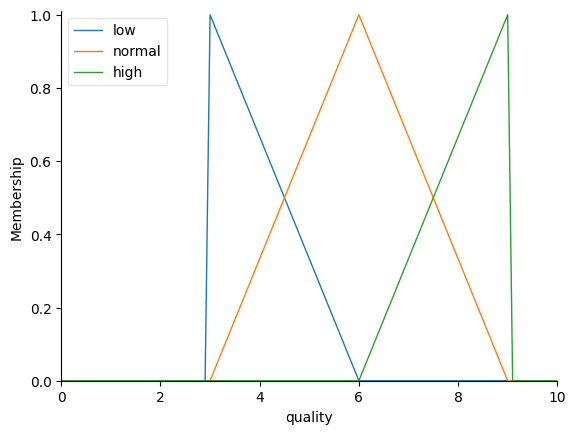

In [20]:
# Define the output variable: wine quality
quality = ctrl.Consequent(np.arange(0, 10.1, 0.1), 'quality')  # Wine quality from 0 to 10

min_val = min(Y)
max_val = max(Y)
center = 6

quality['low'] = fuzz.trimf(quality.universe, [min_val, min_val, center])      
quality['normal'] = fuzz.trimf(quality.universe, [min_val, center, max_val])   
quality['high'] = fuzz.trimf(quality.universe, [center, max_val, max_val]) 

quality.view()


In [21]:
# Define the set of rules

rule1 = ctrl.Rule(pH['ol'] | (pH['low'] & alcohol['ol']), quality['low'])
rule2 = ctrl.Rule((pH['low'] & alcohol['low']) | (sugar['ol']), quality['low'])
rule3 = ctrl.Rule(pH['normal'] & alcohol['normal'], quality['normal'])
rule4 = ctrl.Rule((pH['high'] | sugar['normal']) & alcohol['normal'], quality['normal'])
rule5 = ctrl.Rule((pH['high'] & alcohol['high']) | sugar['high'], quality['high'])
rule6 = ctrl.Rule(pH['oh'] | alcohol['oh'] | sugar['oh'], quality['high'])

In [22]:
# Fuzzy Controller

problem_ctrl  = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])
problem = ctrl.ControlSystemSimulation(problem_ctrl)

pH = 3.33
Alcohol = 12.80
Residual Sugar = 1.20
-------------------------------------------------
Quality of the wine = 7.87


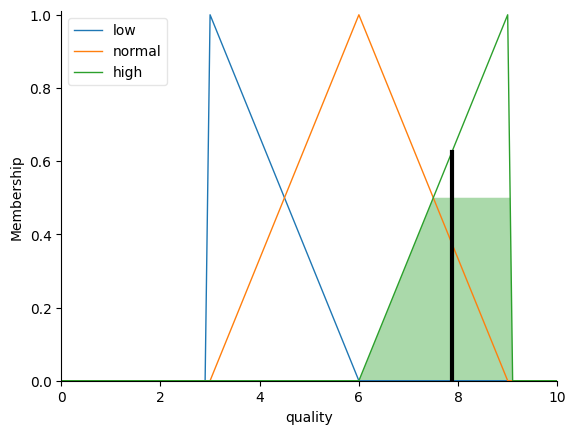

In [23]:
k = 20
print("pH = {:.2f}".format(X.iloc[k, 0]))
print("Alcohol = {:.2f}".format(X.iloc[k, 1]))
print("Residual Sugar = {:.2f}".format(X.iloc[k, 2]))

problem.input['pH'] = X.iloc[k, 0]
problem.input['alcohol'] = X.iloc[k, 1]
problem.input['residual_sugar'] = X.iloc[k, 2]

problem.compute()
print("-------------------------------------------------")
print("Quality of the wine = {:.2f}".format(problem.output['quality']))
quality.view(sim=problem)